In [10]:
import cv2

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from os import path

In [12]:
%matplotlib inline

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [14]:
imgdir = "../data/xcarve/test1/vimgs"

vimgs = sorted([path.join(imgdir, f) for f in os.listdir(imgdir)])

To show some basic SIFT stuff, we're just going to do some operations on the first vimg

In [15]:
def get_img(imgPath):
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray= cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    return img, gray

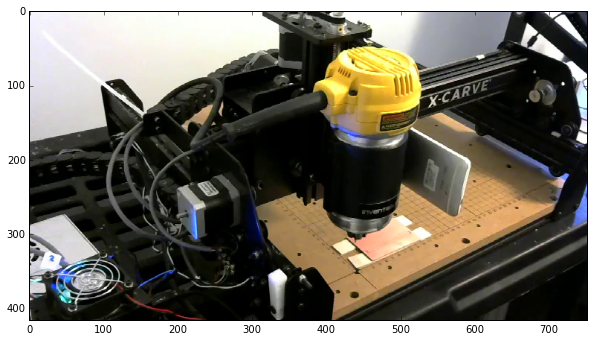

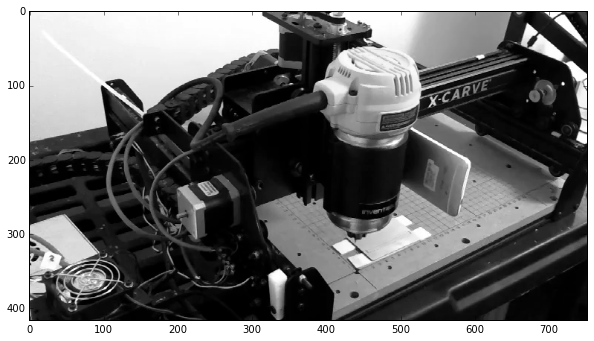

In [16]:
vimg, vimg_g = get_img(vimgs[0])
plt.imshow(vimg)
plt.show()
plt.imshow(vimg_g, cmap=plt.get_cmap('gray'))

In [17]:
sift = cv2.SIFT()

kp = sift.detect(vimg_g,None)

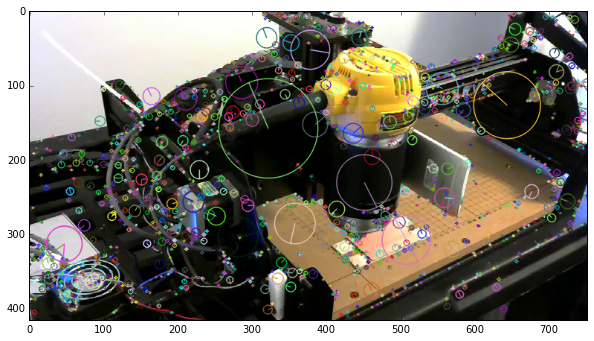

In [18]:
plt.imshow(cv2.drawKeypoints(vimg,kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

Above, we can see all of our SIFT key points, these are good, but we want to know how to CNC changes from one frame to the next. To do this, we use multipleframes where motion occurs. But that is for later :)

[Take a look at this tutorial](http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html)

We're going to begin by manually finding the X-calibration frames, then using them to find features that are moving. These moving features should correspond to the router's x position as they move.

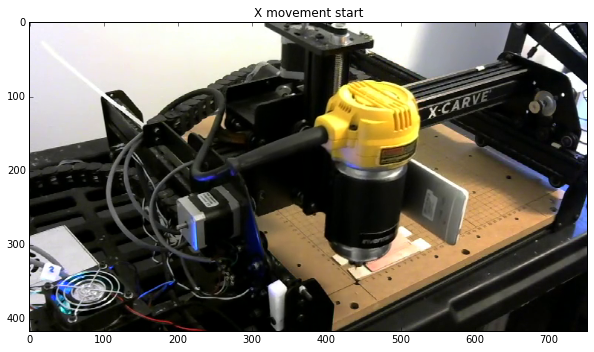

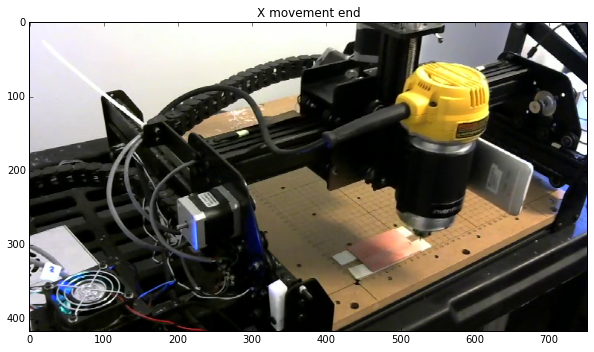

In [46]:
xcal = (149, 225)
(img1,img1_g), (img2, img2_g) = get_img(vimgs[xcal[0]]), get_img(vimgs[xcal[1]])
plt.title("X movement start")
plt.imshow(img1)
plt.show()
plt.title("X movement end")
plt.imshow(img2)
plt.show()

In [47]:
import numpy as np

In [48]:
def dosift(img1, img2,sensitivity=.5):
    sift = cv2.SIFT()
 
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    matchesMask = [[0,0] for i in xrange(len(matches))]
    
    pts1 = []
    pts2 = []
    
    for i,(m,n) in enumerate(matches):
        if m.distance < sensitivity*n.distance:
            pts2.append(np.asarray(kp2[m.trainIdx].pt))
            pts1.append(np.asarray(kp1[m.queryIdx].pt))
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)
    return pts1, pts2

In [49]:
pts1, pts2 = dosift(img1, img2)

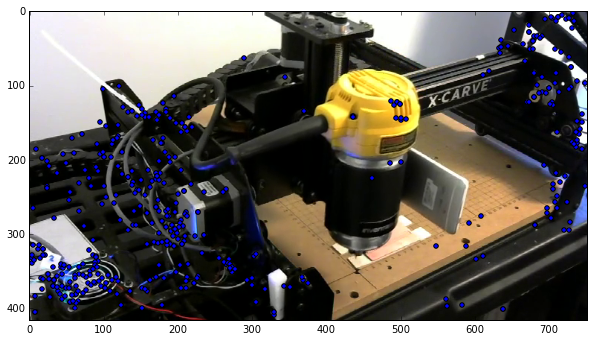

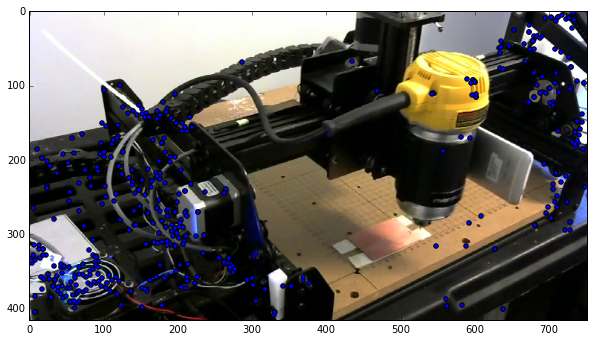

In [51]:
plt.scatter(pts1[:,0], pts1[:,1])
plt.imshow(img1)
plt.show()
plt.scatter(pts2[:,0], pts2[:,1])
plt.imshow(img2)

In [63]:
# remove points that haven't moved significantly
moved = np.ones(len(pts1)).astype(int)
for i,p1,p2 in zip(range(len(pts1)), pts1, pts2):
    if np.sum(np.abs(p1 - p2)) < 50:
        moved[i] = 0

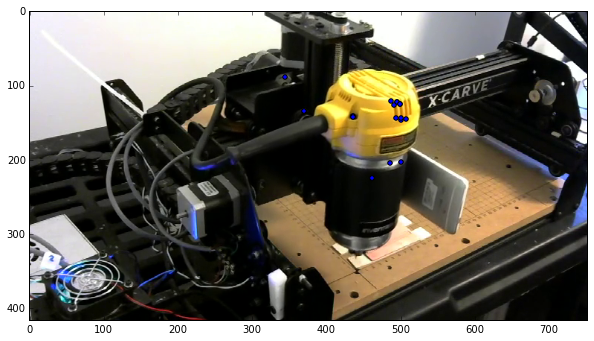

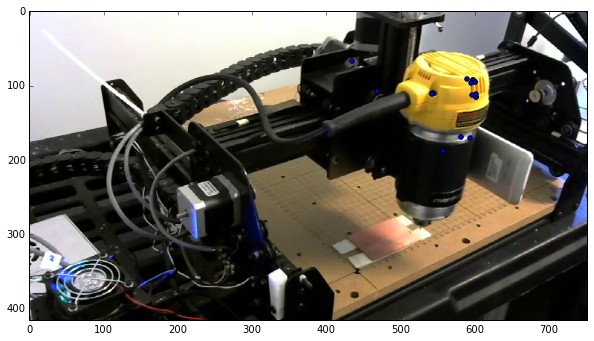

In [64]:
plt.scatter(pts1[moved==1][:,0], pts1[moved==1][:,1])
plt.imshow(img1)
plt.show()
plt.scatter(pts2[moved==1][:,0], pts2[moved==1][:,1])
plt.imshow(img2)

In [65]:
# Let's make those points a new array
p1s, p2s = pts1[moved==1], pts2[moved==1]

In [66]:
# TODO remove noise using simple clustering/variable threshold

In [75]:
# The average point is essentially the x coordinate
avg1 = np.sum(p1s,axis=0)/p1s.shape[0]
avg2 = np.sum(p2s,axis=0)/p2s.shape[0]
avg1,avg2

(array([ 465.19634501,  143.80748028]), array([ 565.07963732,  113.55677838]))

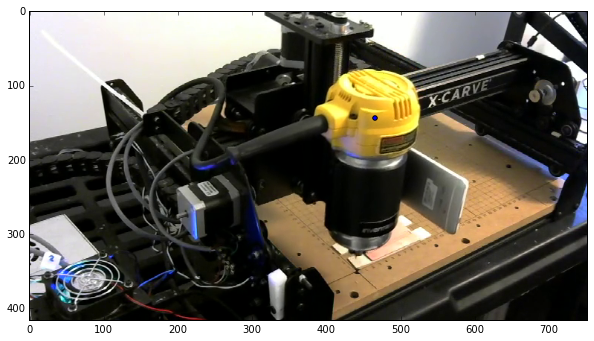

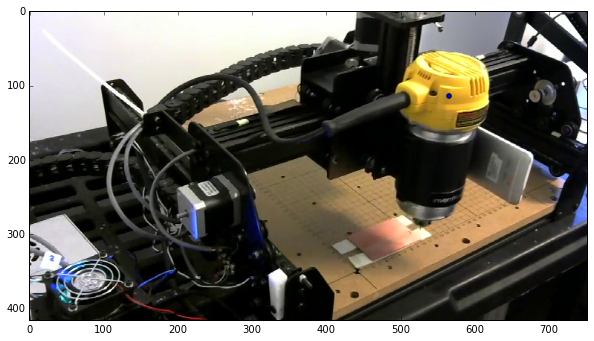

In [77]:
plt.scatter(avg1[0], avg1[1])
plt.imshow(img1)
plt.show()
plt.scatter(avg2[0], avg2[1])
plt.imshow(img2)